# $7^{th}$ exercise

## Notebook setup

#### Used libraries

In [3]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


#### Functions

In [4]:
def Ac(data,dt):
    d0=data[:-dt]
    d1=data[dt:]
    num = np.average(d0*d1) - np.average(d0) * np.average(d1)
    return num/np.var(data)

def Err(ave, av2, n):
    if n == 0:
        return 0
    return np.sqrt((av2 - ave**2) / n)

def DataBlockingErr(data,n_blocks,steps):
    ave=0.
    av2=0.
    for n in range(n_blocks):
        blkave=np.sum(data[n*steps:(n+1)*steps])/steps
        ave+=blkave
        av2+=blkave**2
    return Err(ave/n_blocks, av2/n_blocks,n_blocks-1)

#Plot shortcuts
def PlotSetup():
    plt.axes().set_facecolor(bg1)
    plt.grid(alpha=0.3)

def MultiplotSetup(fig,r,c,nplots=0):
    if nplots == 0 : nplots=r*c
    for i in range(nplots):
        plt.subplot(r,c,i+1)
        fig.axes[i].set_facecolor(bg1)
        plt.grid(alpha=0.3) 
    
def Legend():
    leg = plt.legend(facecolor=bg2)
    for text in leg.get_texts():
        text.set_color(el1)
        
def Errbar1Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.plot(x,y,color=el1)
    
def Errbar2Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.vlines(x,y-2*e,y+2*e,color=er2,alpha=0.4, label="$2\sigma$")
    plt.plot(x,y,color=el1)


#### Useful variables

In [21]:
states = ("solid","liquid","gas")

nm = 1e-9
kb=1.3806485e-23
amu=1.66054e-24

sigma=0.34*nm
eps_kb=120
eps=eps_kb*kb
m=39.948*amu

#### Colors, just for fun

In [6]:
#background
bg1 = "#191724" 
bg2 = "#26233a" 
#elements
el1 = "#e0def4" 
el2 = "#f6c177" 
el3 = "#eb6f92" 
#errorbars
er1 = "#908caa"  
er2 = "#6e6a86"

## 04 - Molecular dynamics in the canonical ensamble: Argon in the Lennard-Jones approximation

A typical experimental situation is one in which we want to study a system at fixed temperature. The canonical ensamble coresponds exactly to this situation. The idea behind the analitical formula for the ensamble probability density is that if temperature is fixed there must be a larger system, the reservoire, that exchange energy with the system under study. As a whole we are dealing with a microcanonical ensambe...

we get

\begin{equation}
p(q,p)=\frac{e^{\beta H(q,p)}}{Z(N,V,T)} 
\end{equation}

How can we sample this pdf whithout knowing the partition function? Metropolis algorithm comes in our help, since there normalization constants cancel out!

We aim to procede step by step into a simulation of a system composed of atoms of argon interacting thorugh a Lennard-Jones potential.

### Radial distribution function and tail corrections
First of all we deal with the problem that introducing a sperical cutoff radius $r_c$ completly elminate the long-range part of the potential. In order to do this we need to introduce the radial distribution function $g(r)$, which express the probability of finding two particles at distance $r$ compared to the probability of finding them at the same distance provided a completly random distribution. Any quantity based on a two-body interaction that depends only on the distance of the particles can be directly evaluated from $g(r)$ by means of an integral over the distances. The key to estimate tail correction is to suppose that outside the spherical cutoff $g(r)\simeq 1$. We then have, in Lennard-Jones units:
\begin{equation}
\frac{V_{tail}}{N}=\frac{8\pi\rho}{9r_c^9}-\frac{8\pi\rho}{3r_c^3}
\end{equation}


\begin{equation}
\frac{W_{tail}}{N}=\frac{32\pi\rho}{9r_c^9}-\frac{16\pi\rho}{3r_c^3}
\end{equation}

### Equilibration

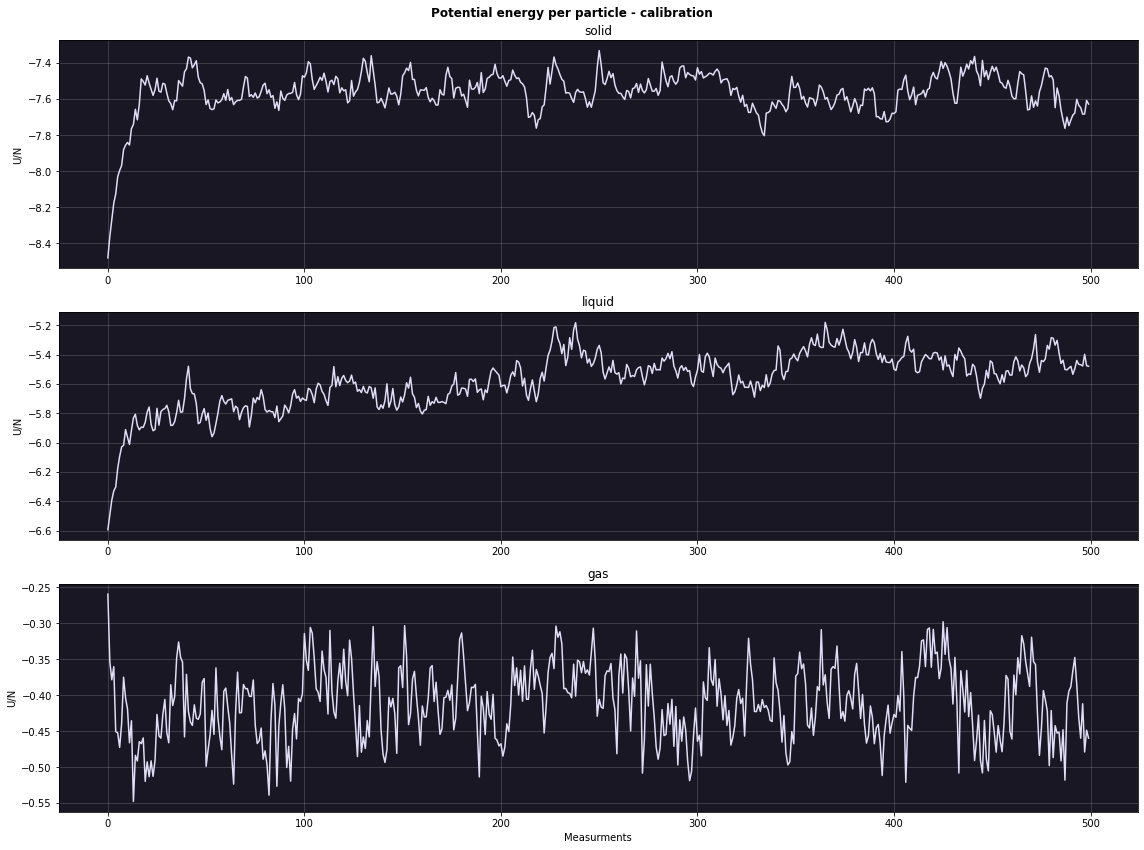

In [7]:
fig=plt.figure(figsize=(16, 12))

plt.suptitle('Potential energy per particle - calibration', weight='bold')

x=np.arange(0,500)
for i in (0,1,2):
    y = np.loadtxt("store/"+states[i]+"/equi.dat", usecols=0,unpack=True)
    y=y[:500]

    plt.subplot(3,1,i+1)
    plt.title(states[i])
    fig.axes[i].set_facecolor(bg1)

    plt.plot(x,y,color=el1)

    plt.ylabel('U/N')
    plt.grid(alpha=0.3)

    


plt.xlabel('Measurments')

plt.tight_layout()
plt.show()

We immediatly observe how the gas stat is a lot less regular than the other two. Having said that, after almost 100 steps our system is equilibrate in all three states.

### Correlation time 
One of the main drawbacks of metropolis is the presence of strong correlations. The auto-correlation function of a random process allows us to estimate how much time is needed for correlation to disappear. It is defined as 
\begin{equation}
Ac_x(\tau)=\frac{\langle x(t)x(t+\tau) \rangle - \langle x(t) \rangle \langle x(t+\tau) \rangle}{\sigma_x^2}
\end{equation}
and we call correlation time $\tau_c$ the caratheristic time lenght of the auto-correlation exponential tail. This mean that for time intervals greater than $\tau_c$ the samples can be considered indipendent. 

We can note that, by choosing sufficently large equilibration times we can consider our process looses all memory of the starting point we choose.

solid  t_c = 11.4243521404988
liquid  t_c = 21.553258710594065
gas  t_c = 2.78113094198228


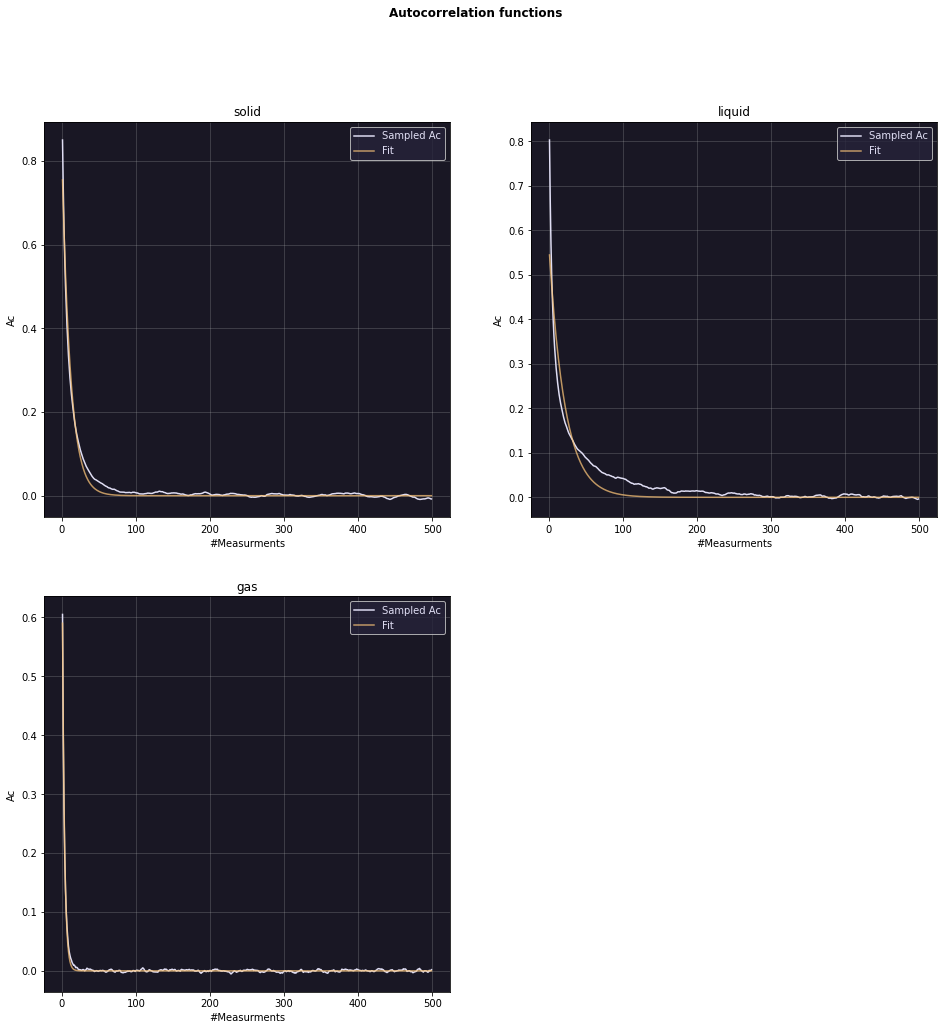

In [10]:
def f(x, t_c, A):
    return  A*np.exp(-x/t_c)

fig=plt.figure(figsize=(16, 16))
x=np.arange(1,500)

plt.suptitle('Autocorrelation functions', weight='bold')

for i in (0,1,2):
    plt.subplot(2,2,i+1)
    plt.title(states[i])
    fig.axes[i].set_facecolor(bg1)

    data = np.loadtxt("store/"+states[i]+"/epot_instant.dat", usecols=0,unpack=True)
    y=np.fromiter((Ac(data,i) for i in x),np.double)
    plt.plot(x,y,color=el1, label="Sampled Ac")
    
    popt, pcov = curve_fit(f, x, y)
    plt.plot(x, f(x, *popt), label="Fit", color=el2, alpha=0.75)

    plt.ylabel('Ac')
    plt.xlabel('#Measurments')

    Legend()
    plt.grid(alpha=0.3)
    
    print(states[i]," t_c =", popt[0])

plt.show()

### Block size
Since we are using a markov chain, by increasing the lenght of the block we reach the true statistical error and by increasing the lenght further more we shouldn't gain anything from the error perspective. So studying when the error stops growing in function of the blocks size is a good indicator of how large a block should be.

In [11]:
block_lenghts=np.linspace(10,5000,100,dtype='int')

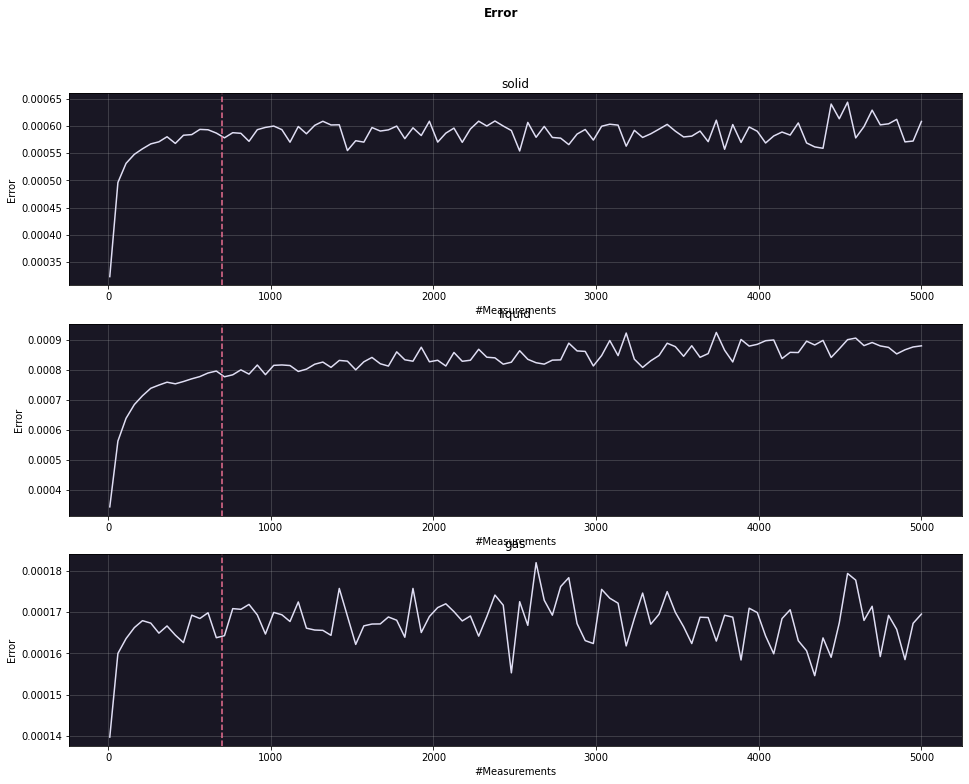

In [12]:
fig=plt.figure(figsize=(16, 12))

plt.suptitle('Error', weight='bold')

for i in (0,1,2):
    plt.subplot(3,1,i+1)
    plt.title(states[i])
    fig.axes[i].set_facecolor(bg1)
    data = np.loadtxt("store/"+states[i]+"_epot_instant.dat", usecols=0,unpack=True)
    y=np.fromiter((DataBlockingErr(data,int(5e5/L),L) for L in block_lenghts),np.double)

    plt.plot(block_lenghts,y,color=el1)
    plt.axvline(700,ls="--", color=el3)

    plt.ylabel('Error')
    plt.xlabel('#Measurements')

    plt.grid(alpha=0.3)


plt.show()

As we can see, after 700 steps the error completly saturates. 

### Simulation
Whith the insight gained we can perform the actual simulation. We want to estimate potential energy per particle and pressure in the phases:
- Solid $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- Liquid $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- Gas $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)
We also want to estimate $g(r)$. To do that, for each block we divided the interval $[0,L/2)$ (with $L$ the box lenght) in 100 bins $[b_i,b_{i+1})$ and increased the count of a bin by two each time the distance $r_{ij}\in[b_i,b_{i+1})$. In the end we averaged the $g(r)$ found for each block.

#### Solid

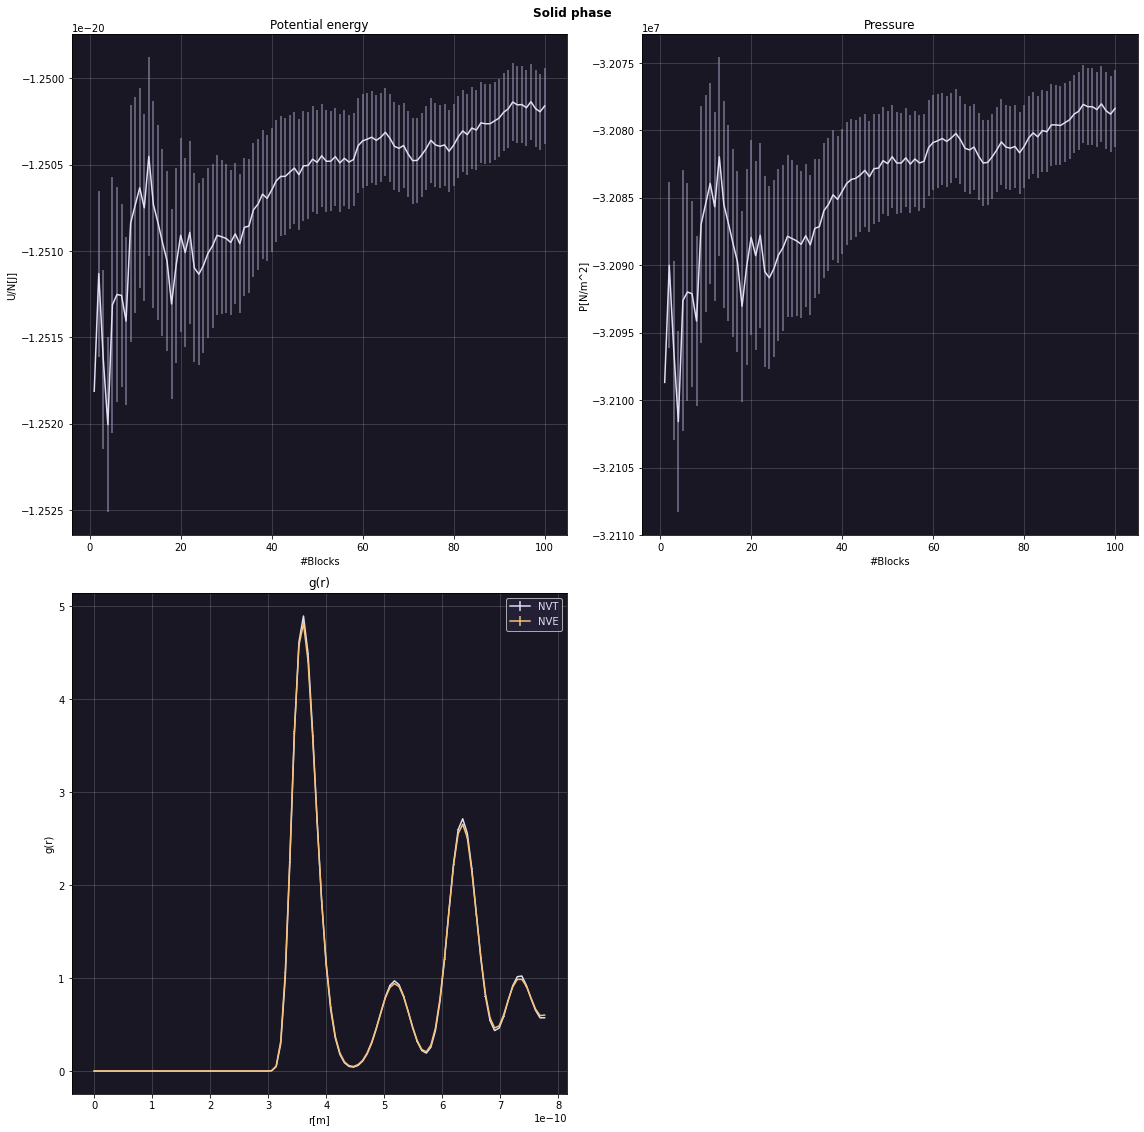

In [25]:
state="solid"
fig=plt.figure(figsize=(16, 16))
plt.suptitle('Solid phase', weight='bold')
MultiplotSetup(fig,2,2,3)

#potential energy
plt.subplot(221)
plt.title("Potential energy")
plt.xlabel('#Blocks')
plt.ylabel('U/N[J]')

x,y,e = np.loadtxt("store/"+state+"/output_epot.dat", usecols=(0,2,3),unpack=True)
y*=eps
e*=eps

Errbar1Sigma(x,y,e)

#Pressure
plt.subplot(222)
plt.title("Pressure")
plt.xlabel('#Blocks')
plt.ylabel('P[N/m^2]')

x,y,e = np.loadtxt("store/"+state+"/output_pres.dat", usecols=(0,2,3),unpack=True)
y*=eps/sigma**3
e*=eps/sigma**3

Errbar1Sigma(x,y,e)


#g(r)
plt.subplot(223)
plt.title("g(r)")
plt.xlabel('r[m]')
plt.ylabel('g(r)')

x,y_nvt,e_nvt = np.loadtxt("store/"+state+"/output_gfin_nvt.dat", usecols=(0,1,2),unpack=True)
x,y_nve,e_nve = np.loadtxt("store/"+state+"/output_gfin_nve.dat", usecols=(0,1,2),unpack=True)
x*=sigma

plt.errorbar(x,y_nvt,yerr=e_nvt,color=el1,label="NVT")
plt.errorbar(x,y_nve,yerr=e_nve,color=el2,label="NVE")

Legend()


plt.tight_layout()


plt.show()

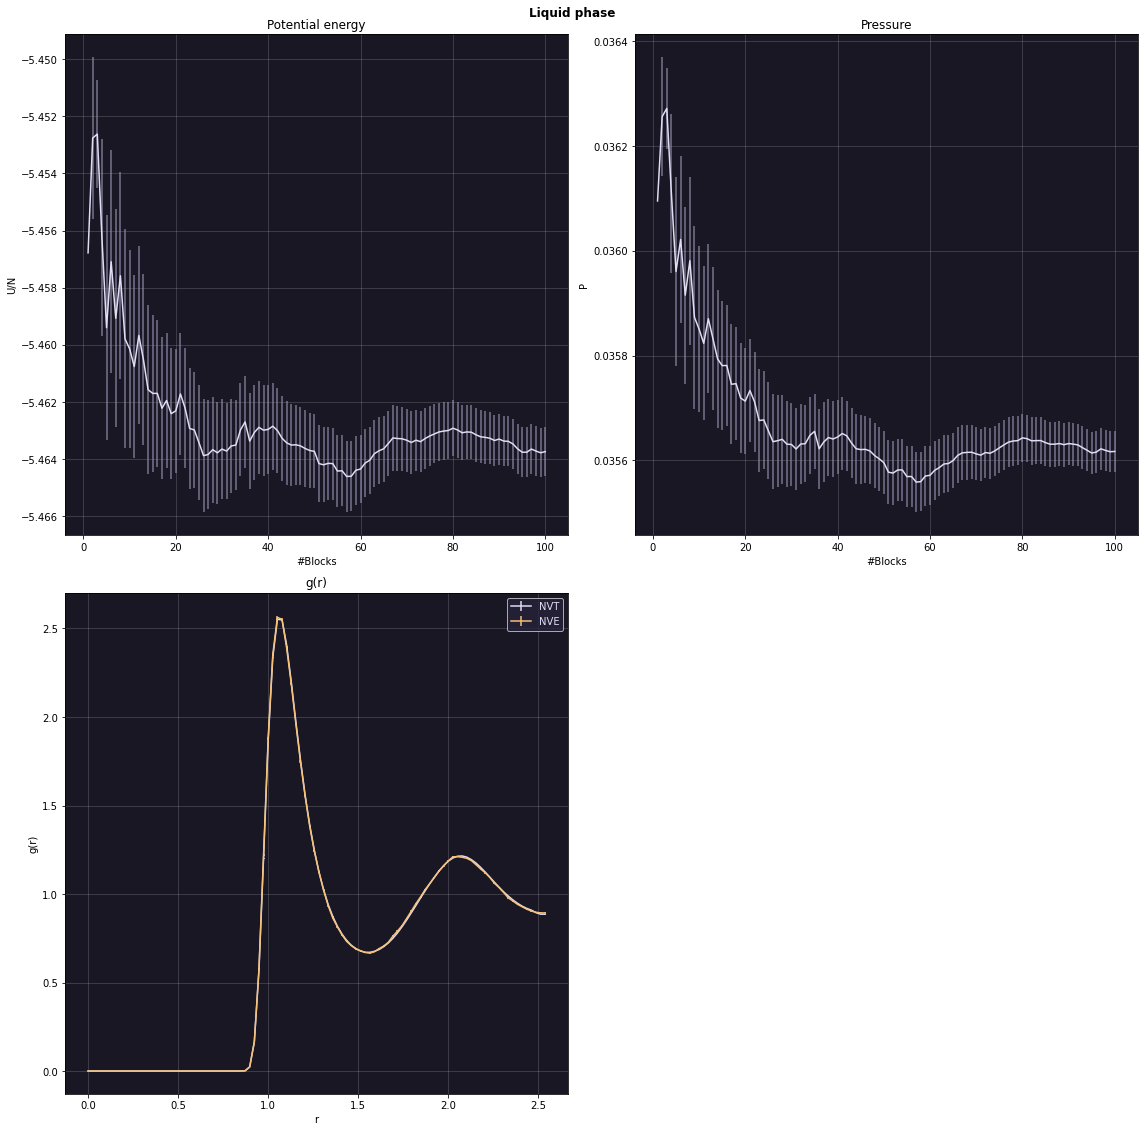

In [19]:
state="liquid"
fig=plt.figure(figsize=(16, 16))
plt.suptitle('Liquid phase', weight='bold')
MultiplotSetup(fig,2,2,3)

#potential energy
plt.subplot(221)
plt.title("Potential energy")
plt.xlabel('#Blocks')
plt.ylabel('U/N[J]')

x,y,e = np.loadtxt("store/"+state+"/output_epot.dat", usecols=(0,2,3),unpack=True)
y*=eps
e*=eps

Errbar1Sigma(x,y,e)

#Pressure
plt.subplot(222)
plt.title("Pressure")
plt.xlabel('#Blocks')
plt.ylabel('P[N/m^2]')

x,y,e = np.loadtxt("store/"+state+"/output_pres.dat", usecols=(0,2,3),unpack=True)
y*=eps/sigma**3
e*=eps/sigma**3

Errbar1Sigma(x,y,e)


#g(r)
plt.subplot(223)
plt.title("g(r)")
plt.xlabel('r[m]')
plt.ylabel('g(r)')

x,y_nvt,e_nvt = np.loadtxt("store/"+state+"/output_gfin_nvt.dat", usecols=(0,1,2),unpack=True)
x,y_nve,e_nve = np.loadtxt("store/"+state+"/output_gfin_nve.dat", usecols=(0,1,2),unpack=True)
x*=sigma

plt.errorbar(x,y_nvt,yerr=e_nvt,color=el1,label="NVT")
plt.errorbar(x,y_nve,yerr=e_nve,color=el2,label="NVE")

Legend()


plt.tight_layout()


plt.show()

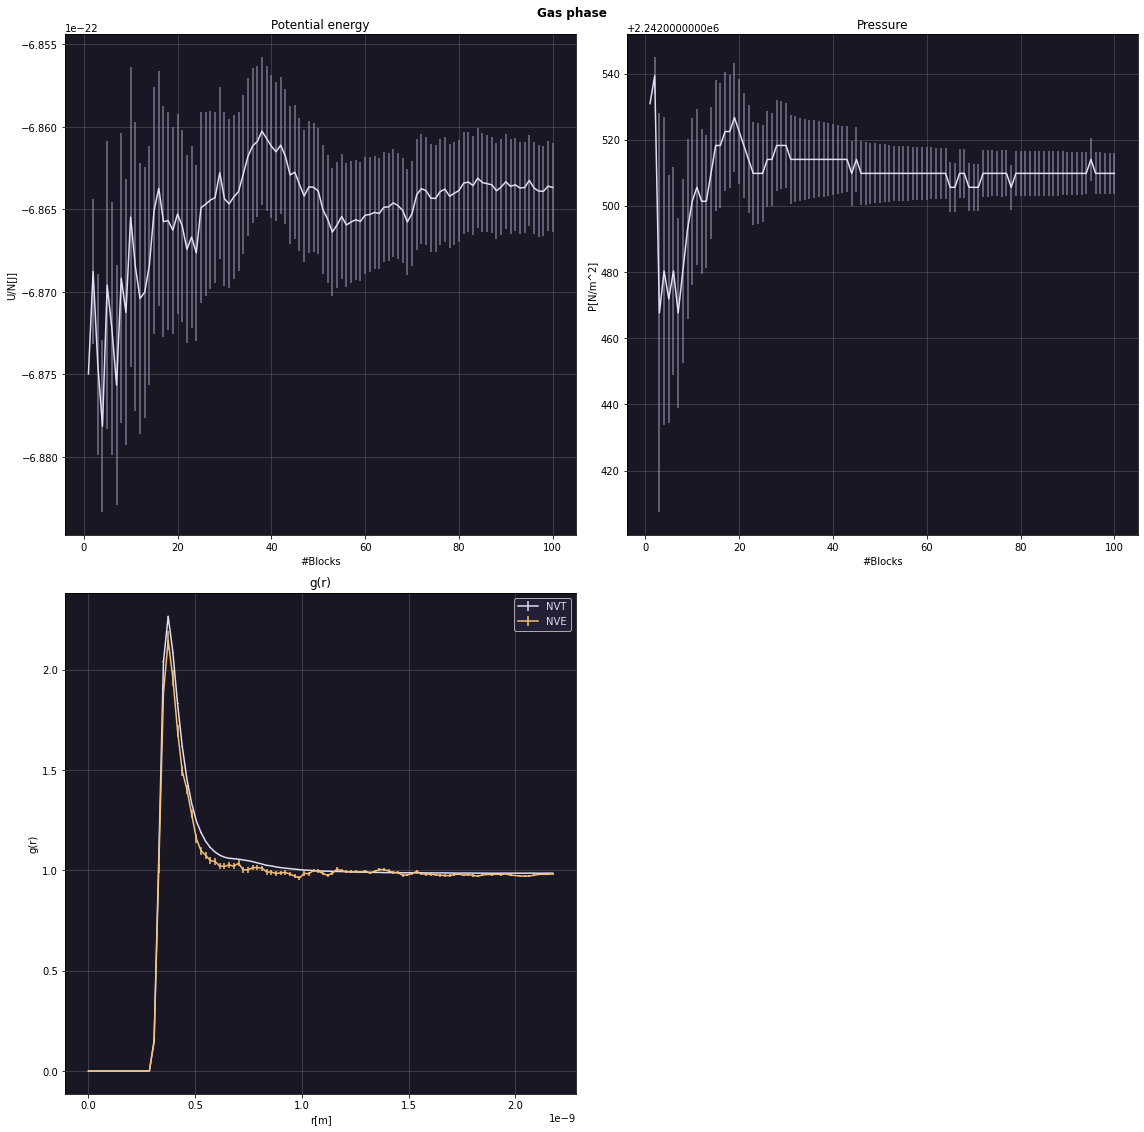

In [26]:
state="gas"
fig=plt.figure(figsize=(16, 16))
plt.suptitle('Gas phase', weight='bold')
MultiplotSetup(fig,2,2,3)

#potential energy
plt.subplot(221)
plt.title("Potential energy")
plt.xlabel('#Blocks')
plt.ylabel('U/N[J]')

x,y,e = np.loadtxt("store/"+state+"/output_epot.dat", usecols=(0,2,3),unpack=True)
y*=eps
e*=eps

Errbar1Sigma(x,y,e)

#Pressure
plt.subplot(222)
plt.title("Pressure")
plt.xlabel('#Blocks')
plt.ylabel('P[N/m^2]')

x,y,e = np.loadtxt("store/"+state+"/output_pres.dat", usecols=(0,2,3),unpack=True)
y*=eps/sigma**3
e*=eps/sigma**3

Errbar1Sigma(x,y,e)


#g(r)
plt.subplot(223)
plt.title("g(r)")
plt.xlabel('r[m]')
plt.ylabel('g(r)')

x,y_nvt,e_nvt = np.loadtxt("store/"+state+"/output_gfin_nvt.dat", usecols=(0,1,2),unpack=True)
x,y_nve,e_nve = np.loadtxt("store/"+state+"/output_gfin_nve.dat", usecols=(0,1,2),unpack=True)
x*=sigma

plt.errorbar(x,y_nvt,yerr=e_nvt,color=el1,label="NVT")
plt.errorbar(x,y_nve,yerr=e_nve,color=el2,label="NVE")

Legend()


plt.tight_layout()


plt.show()

RIFACCIO CON DATI GIUSTI!!!!!